# PyTorch

This notebook will cover how we can implement fully-connected neural networks using PyTorch. We'll first provide an overview of neural networks at a theoretical level, then we will walk throught the implementation of a neural network to classify the ASL symbol for the letter A versus the letter B, using our MediaPipe hand landmarks from last week.

<a href="https://colab.research.google.com/github/MichiganDataScienceTeam/W26-Sign-Language-Translator/blob/main/Week%202/intro_to_pytorch_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If opening via Colab, be sure to make a copy of the notebook first to save your progress!

- To make a copy of the notebook: `File > Save as copy to Drive`
- To enable GPU for model training: `Runtime > Change Runtime Type > T4 GPU > Save`

To install MediaPipe on Google Colab, you'll need to pip install it manually with the code cell below (uncommenting the relevent line). If the `hand_landmarker.task` is not downloaded for MediaPipe, you can use `wget` to download it to your current directory.

In [10]:
# !pip install mediapipe
# !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Intro to Neural Networks

### Perceptron
A **perceptron** is the simplest form of a neural network unit. It takes weighted inputs, adds a bias term, and outputs either 0 or 1 based on a threshold:

- **Input**: A vector of features $x_1, x_2, ..., x_n$
- **Weights**: Learnable parameters $w_1, w_2, ..., w_n$
- **Bias**: A learnable offset term $b$
- **Decision Rule**: Output 1 if $\sum(w_i \cdot x_i) + b > 0$, else output 0

### Neurons and Activation Functions
Modern neural networks generalize the perceptron by using **neurons** with **activation functions**. Instead of a simple threshold, we apply a function to the weighted sum:

- **Linear Combination**: $z = \sum(w_i \cdot x_i) + b$
- **Activation**: $h = f(z)$ where $f$ is an activation function

Common activation functions include:
- **ReLU (Rectified Linear Unit)**: $f(z) = \max(0, z)$
    - Most popular activation, particularly since it promotes sparseness in the resulting neural network (since some neurons will output zero). This concentrates the contribution to the output to a smaller subset of neurons, which mitigates the vanishing gradient problem during training compared to other activation functions.
    - [Vanishing Gradient Problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)
- **Sigmoid**: $f(z) = \frac{1}{1 + e^{-z}}$ - outputs in range [0, 1]
- **Tanh**: $f(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ - squashes output to range [-1, 1]

### Fully-Connected Layers
A **fully-connected (dense) layer** consists of many neurons where each output neuron is connected to every input. These layers learn complex patterns through multiple layers stacked together.

### Neural Networks
A **neural network** is a collection of layers stacked together:
- **Input Layer**: The raw features, which in our case are coordinates of hand landmarks i
    - each value in the input tensor is either an $x$ or a $y$
- **Hidden Layers**: Intermediate layers that learn abstract representations
- **Output Layer**: Final predictions for each class

The depth of a network (number of layers) allows it to learn increasingly complex patterns through feature hierarchy.


## Imports and Setup

The below cell imports PyTorch, along with matplotlib for visualization and numpy for basic matrix operations.

If you would like to work through a more principled tutorial for PyTorch, we recommend looking through the official PyTorch tutorial series (either on the [docs](https://pytorch.org/tutorials/beginner/basics/intro.html) or on [YouTube](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN))! Feel free to ask us questions also!

In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from dataloader import get_dataloader

# CUDA: Nvidia CUDA-enabled GPU
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")

# MPS: Apple Silicon
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")

# CPU: 
else:
    print("Using CPU")
    device = torch.device("cpu")

Using MPS


## Loading Training and Validation Data

We'll use hand landmark data extracted from images of ASL letters. The data has been preprocessed into hand landmark tensors with 42 features (21 landmarks × 2 coordinates).

For this introduction, we'll focus on classifying between letters **A** and **B** as a binary classification task. We've provided a `get_dataloader` function that returns a PyTorch `DataLoader` instance.

- `Dataset` ([docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) is an iterable data structure that represents a collection of data to be used as input to deep learning models. It defines an interface to access the underlying datapoints of the dataset.
- `DataLoader` ([docs](https://pytorch.org/docs/stable/data.html?highlight=data+loader#torch.utils.data.DataLoader)) prepares data into batches for training neural networks (using mini-batch stochastic gradient descent), wrapping an input `Dataset` object. `DataLoader` also offers parallelization methods that make training faster.

The two main parameters of the dataloader are `shuffle` and `batch_size`:

- `shuffle=True` means that small, randomly sampled subsets (mini-batches) are used, which promotes different update directions for each update iteration. This helps to avoid converging to a local minimum which may be suboptimal compared to a global minimum which may exist elsewhere in the parameter space (possible settings of the model weights+biases).
- `batch_size=32` means that the weights of the model are updated based on the average of a collection of 32 gradients corresponding to 32 data points.
- If you'd like to read more on mini-batch SGD, [here](https://developers.google.com/machine-learning/crash-course/linear-regression/hyperparameters) is a writeup that may be a helpful starting place.

In [12]:
batch_size = 32

train_loader = get_dataloader(
    dataset_name="asl_letters_small",
    partition="train",
    as_landmarks=True,
    batch_size=batch_size,
    shuffle=True
)

val_loader = get_dataloader(
    dataset_name="asl_letters_small",
    partition="val",
    as_landmarks=True,
    batch_size=batch_size,
    shuffle=False
)

I0000 00:00:1769986582.182987 31980159 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1769986582.189125 31980161 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769986582.194502 31980168 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1769986582.214636 31980172 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1769986582.219210 31980177 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769986582.222638 31980177 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Let's examine the data to understand its structure:

In [13]:
# Get a sample batch to understand data dimensions
for landmarks, labels in train_loader:
    print(f"Landmarks shape: {landmarks.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Sample landmark vector: {landmarks[0]}")
    print(f"Sample label: {labels[0]}")
    break

Landmarks shape: torch.Size([32, 42])
Labels shape: torch.Size([32])
Sample landmark vector: tensor([ 0.0000,  0.0000,  0.0980, -0.0640,  0.1548, -0.1728,  0.1692, -0.2682,
         0.1673, -0.3399,  0.1107, -0.2376,  0.1140, -0.3184,  0.1105, -0.2661,
         0.1097, -0.2011,  0.0434, -0.2269,  0.0453, -0.3154,  0.0557, -0.2482,
         0.0666, -0.1791, -0.0204, -0.2075, -0.0125, -0.2576,  0.0015, -0.1766,
         0.0095, -0.1124, -0.0822, -0.1796, -0.0655, -0.2249, -0.0557, -0.1667,
        -0.0512, -0.1161])
Sample label: 0


Labels are integers representing different ASL letters. In this case, they are indices of the list `["A", "B"]`.

## Defining a Fully-Connected Neural Network

Now we'll create a neural network model by defining a custom class that inherits from `nn.Module`. The key requirements are:

1. **Inherit from `nn.Module`**: This base class provides all the necessary functionality for PyTorch models
2. **Define layers in `__init__`**: Declare all layers as member variables
3. **Implement `forward` method**: Specify how data flows through the network

### Fully-Connected Layers in PyTorch

A fully-connected (dense) layer in PyTorch is created using `nn.Linear`:

```python
fc_layer = nn.Linear(in_features=42, out_features=256)
```

- **`in_features`**: The dimensionality of the input (e.g., 42 hand landmark coordinates)
- **`out_features`**: The dimensionality of the output (number of neurons in this layer)

### Activation Functions

After each linear transformation, we apply an activation function to introduce non-linearity:

```python
relu = nn.ReLU()  # Rectified Linear Unit
```


In [14]:
class AvB_Model(nn.Module):
    def __init__(self, input_features=42, num_classes=2):
        super(AvB_Model, self).__init__()  # Call superclass constructor
        
        # Define fully-connected layers
        self.fc1 = torch.nn.Linear(42, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)

        # Define activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc3(x)
        return x

    
    def forward(self, x):
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 42)
            
        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # First fully-connected layer + ReLU activation
        z1 = self.fc1(x)
        h1 = self.relu(z1)
        
        # Second fully-connected layer + ReLU activation
        z2 = self.fc2(h1)
        h2 = self.relu(z2)
        
        # Output layer (no activation, will be used with CrossEntropyLoss)
        z3 = self.fc3(h2)
        
        return z3

### Understanding the Network Architecture

Our network has the following structure:

1. **Input Layer**: 42 features (hand landmarks)
2. **Hidden Layer 1**: 256 neurons → ReLU activation
3. **Hidden Layer 2**: 128 neurons → ReLU activation
4. **Output Layer**: 24 neurons (one for each ASL letter)

The `forward` method defines the forward pass of the input through the neural network:
- Each layer applies the linear transformation: $z = Wx + b$
- ReLU activation introduces non-linearity: $h = \max(0, z)$
- The final layer outputs raw scores (logits) without activation

The backward pass is automatically defined by PyTorch based on the definition of the forward pass, using a process called [automatic differentiation](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) to keep track of operations using a computational graph.



## Training
Neural networks are trained using:
- **Loss Function**: Measures how wrong predictions are (Cross-Entropy Loss for classification)
- **Optimizer**: Updates weights using gradient descent (SGD, Adam)
- **Mini-Batch Training**: Updates on small batches of data for efficiency
- **Epochs**: Full passes through the training data

## Training Loop

To train a neural network, we need to:
1. Define a **loss function** to measure prediction error
2. Define an **optimizer** to update weights based on gradients
3. Iterate through data in **mini-batches** for efficient training
4. Update weights using **backpropagation**

In [ ]:
# Initialize model, loss function, and optimizer
model = AvB_Model(input_features=42, num_classes=2)
model.to(device)

# CrossEntropyLoss combines softmax and negative log-likelihood
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.001)
# The Adam optimizer tends to converge much 
# more quickly with this dataset compared to 
# using Stochastic Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model:\n{model}")

Model:
AvB_Model(
  (fc1): Linear(in_features=42, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


### The Training Loop

The standard PyTorch training loop follows this pattern:

```python
for epoch in range(num_epochs):
    for batch in dataloader:
        # 1. Forward pass: compute predictions
        outputs = model(inputs)
        
        # 2. Compute loss
        loss = criterion(outputs, targets)
        
        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Compute new gradients
        
        # 4. Update weights
        optimizer.step()
```

In [16]:
# Training parameters
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for landmarks, labels in train_loader:
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()              # reset gradients
        outputs = model(landmarks)         # make a prediction using the model (forward pass)
        loss = criterion(outputs, labels)  # compare predictions to ground truth labels
        loss.backward()                    # calculate gradients (backward pass)
        optimizer.step()                   # update parameters
        
        # Track metrics
        epoch_train_loss += loss.item() * landmarks.size(0)
        _, predicted = torch.max(outputs, 1)
        epoch_train_correct += (predicted == labels).sum().item()
        epoch_train_total += labels.size(0)
    
    # Average training metrics for epoch
    avg_train_loss = epoch_train_loss / epoch_train_total
    avg_train_acc = epoch_train_correct / epoch_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # set model to eval mode (no updating of weights)
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        # check performance on validation dataset
        for landmarks, labels in val_loader:
            landmarks = landmarks.to(device)
            labels = labels.to(device)
            
            outputs = model(landmarks)
            
            loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item() * landmarks.size(0)
            _, predicted = torch.max(outputs, 1)
            epoch_val_correct += (predicted == labels).sum().item()
            epoch_val_total += labels.size(0)
    
    # Average validation metrics for epoch
    avg_val_loss = epoch_val_loss / epoch_val_total
    avg_val_acc = epoch_val_correct / epoch_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc*100:.2f}%")

save_path = "./AvB_fc_model.pth"
torch.save(model.state_dict(), save_path)
print(f"saved model to {save_path}: {val_accuracies[-1]:.2f}% accuracy")

Epoch [1/10] - Train Loss: 0.6453, Train Acc: 85.78% | Val Loss: 0.5627, Val Acc: 99.17%
Epoch [2/10] - Train Loss: 0.4512, Train Acc: 99.54% | Val Loss: 0.2969, Val Acc: 99.17%
Epoch [3/10] - Train Loss: 0.1803, Train Acc: 99.54% | Val Loss: 0.0737, Val Acc: 100.00%
Epoch [4/10] - Train Loss: 0.0400, Train Acc: 100.00% | Val Loss: 0.0175, Val Acc: 100.00%
Epoch [5/10] - Train Loss: 0.0124, Train Acc: 99.77% | Val Loss: 0.0075, Val Acc: 100.00%
Epoch [6/10] - Train Loss: 0.0073, Train Acc: 99.77% | Val Loss: 0.0047, Val Acc: 100.00%
Epoch [7/10] - Train Loss: 0.0052, Train Acc: 100.00% | Val Loss: 0.0040, Val Acc: 100.00%
Epoch [8/10] - Train Loss: 0.0045, Train Acc: 99.77% | Val Loss: 0.0029, Val Acc: 100.00%
Epoch [9/10] - Train Loss: 0.0049, Train Acc: 100.00% | Val Loss: 0.0038, Val Acc: 100.00%
Epoch [10/10] - Train Loss: 0.0030, Train Acc: 100.00% | Val Loss: 0.0021, Val Acc: 100.00%
saved model to ./AvB_fc_model.pth: 1.00% accuracy


## Visualizing Training Progress

Let's plot the training and validation curves to understand how well our model is learning:

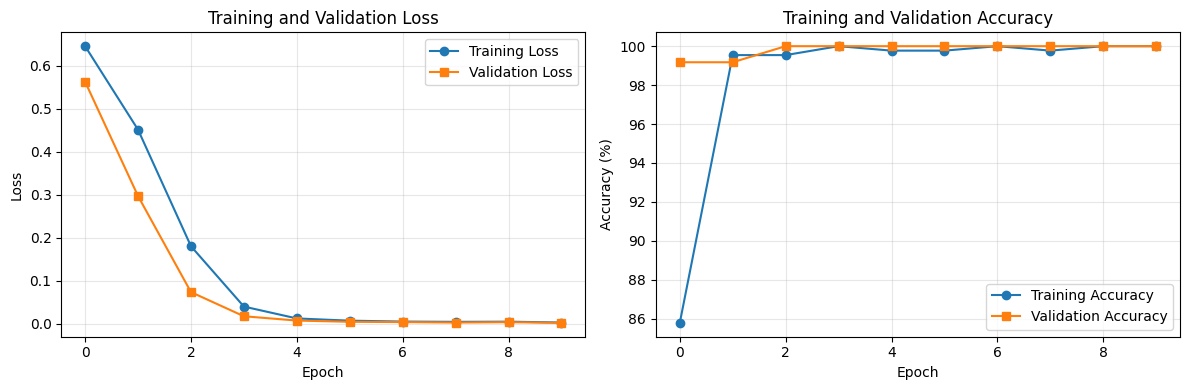


Final Results:
Training Accuracy: 100.00%
Validation Accuracy: 100.00%


In [17]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
epochs_range = np.arange(len(train_losses))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, np.array(train_accuracies) * 100, label='Training Accuracy', marker='o')
plt.plot(epochs_range, np.array(val_accuracies) * 100, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1]*100:.2f}%")

# Testing

The below code implements a live webcam loop, which processes each frame from your webcamera using a provided `ImageToTensorPreprocessor` class to convert video frames containing hands to hand landmark tensors. If a hand is detected, the landmarks are provided as input to your trained model, and the result is drawn on the video frame before it is then show on the screen with `cv2.imshow("Image", annotated_img)`

**Note:** Here, we process the output of the model using `torch.softmax`, instead of our loss function from before `torch.CrossEntropyLoss`.

**Note:** This cell will not work if you are running your notebook on Google Colab.

In [18]:
import cv2
from dataloader import ImageToTensorPreprocessor, label_to_letter

model = AvB_Model()
model.load_state_dict(torch.load("AvB_fc_model.pth"))
model.to(device)
model.eval()

cap = cv2.VideoCapture(0)
find_hands = ImageToTensorPreprocessor(output_format="landmarks", static_image_mode=False)
while True:
    success, annotated_img = cap.read()
    annotated_img = cv2.flip(annotated_img, 1)
    key = cv2.waitKey(1) & 0xFF
    landmarks = find_hands(annotated_img)
    if landmarks is not None:
        landmarks = landmarks.to(device)
        classification = model(landmarks)
        predicted_label = torch.argmax(classification, dim=-1).item()
        predicted_letter = label_to_letter(predicted_label)
        confidence = torch.softmax(classification, dim=-1).max().item() * 100

        annotated_img = find_hands.draw_hand_landmarks(
            annotated_img,
            text = f"Predicted: {predicted_letter} ({confidence:.1f}%)"
        )
    cv2.imshow("Image", annotated_img)
    if key == ord("q"):
        break

I0000 00:00:1769986710.672126 31986661 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1769986710.676453 31986663 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769986710.681462 31986663 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Dropout

Dropout is a regularization technique that randomly zeros out neurons during training to prevent overfitting:

During classification, all neurons are used, with activations scaled by $1/(1-p)$

```python
dropout = nn.Dropout(0.5)  # Randomly drop 50% of neurons


class AvB_Model(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(AvB_Model, self).__init__()
        self.fc1 = torch.nn.Linear(42, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc3(x)
        return x
```

## Adam Optimizer (Adaptive Moment Estimation)

The Adam optimizer improves performance over SGD by adaptively adjusting individual learning rates for each parameter using estimates of first and second gradient moments, which typically leads to faster and more stable convergence.

```python
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)
```